<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<div class="markdown-google-sans">
  <h2>Explore the Gemini API</h2>
  <p>The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.
  </p>
  <strong>How to get started</strong>
    <ol>
      <li>Go to <a href="https://aistudio.google.com/">Google AI Studio</a> and log in with your Google account.</li>
      <li><a href="https://aistudio.google.com/app/apikey">Create an API key</a>.</li>
      <li>Use a quickstart for <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Prompting.ipynb">Python</a>, or call the REST API using <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a>.</li>
      </ol>
  <strong>Explore use cases</strong>
    <ul>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Market_a_Jet_Backpack.ipynb">Create a marketing campaign</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Audio.ipynb">Analyze audio recordings</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/System_instructions.ipynb">Use System instructions in chat</a></li>
    </ul>
  <p>To learn more, check out the <a href="https://github.com/google-gemini/cookbook">Gemini cookbook</a> or visit the <a href="https://ai.google.dev/docs/">Gemini API documentation</a>.
  </p>
</div>


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths
zip_file_path = '/content/drive/MyDrive/video activity.zip'
extracted_folder_path = '/content/drive/MyDrive/datasetvideo'

In [ ]:
# Extract dataset
import zipfile
os.makedirs(extracted_folder_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [ ]:
# Constants
frames_per_video = 16
height, width, channels = 64, 64, 3
input_shape = (frames_per_video, height, width, channels)
num_classes = 2
batch_size = 32
epochs = 20

In [ ]:
# Function to preprocess video frames
def preprocess_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (width, height))
        frames.append(frame)
        frame_count += 1
        if frame_count == frames_per_video:
            break
    cap.release()

    frames = np.array(frames)
    if len(frames) < frames_per_video:
        frames = np.pad(frames, ((0, frames_per_video - len(frames)), (0, 0), (0, 0), (0, 0)), 'constant')
    return frames

In [ ]:
# Function to load data from folders
def load_data_from_folder(class_folder, class_name):
    videos = []
    labels = []

    for video_name in os.listdir(class_folder):
        video_path = os.path.join(class_folder, video_name)
        frames = preprocess_video(video_path)
        if frames.shape[0] == frames_per_video:
            videos.append(frames)
            labels.append(class_name)

    return np.array(videos), np.array(labels)

In [ ]:
# Load dataset
data_folder = '/content/drive/MyDrive/datasetvideo'
normal_videos_folder = os.path.join(data_folder, 'normal activity')
abnormal_videos_folder = os.path.join(data_folder, 'abnormal activity')

normal_videos, normal_labels = load_data_from_folder(normal_videos_folder, 0)
abnormal_videos, abnormal_labels = load_data_from_folder(abnormal_videos_folder, 1)



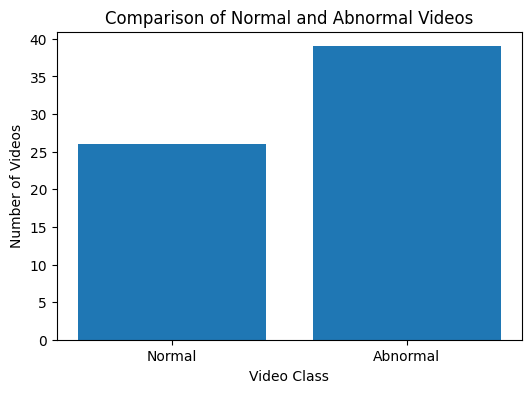

In [ ]:
# Plot data distribution
class_labels = ['Normal', 'Abnormal']
class_counts = [len(normal_videos), len(abnormal_videos)]
plt.figure(figsize=(6, 4))
plt.bar(class_labels, class_counts)
plt.xlabel('Video Class')
plt.ylabel('Number of Videos')
plt.title('Comparison of Normal and Abnormal Videos')
plt.show()

In [ ]:
# Prepare data
videos = np.concatenate((normal_videos, abnormal_videos), axis=0)
labels = np.concatenate((normal_labels, abnormal_labels), axis=0)
labels = to_categorical(labels, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

In [ ]:
# Build model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
with tf.device('/device:GPU:0'):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.5385 - loss: 59.0030 - val_accuracy: 0.6154 - val_loss: 351.2681
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.6442 - loss: 223.5305 - val_accuracy: 0.3846 - val_loss: 57.2426
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.4255 - loss: 45.1933 - val_accuracy: 0.6154 - val_loss: 2.9890
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.6418 - loss: 2.2272 - val_accuracy: 0.7692 - val_loss: 1.0052
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.6931 - loss: 0.8149 - val_accuracy: 0.6154 - val_loss: 0.9643
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.8117 - loss: 0.4315 - val_accuracy: 0.6154 - val_loss: 1.0875
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.8349 - loss: 0.3206 - val_accuracy: 0.4615 - val_loss: 1.5900
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.8942 - loss: 0.2206 - val_accuracy: 0.5385 - val_loss: 2.4784
E

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/ATM_theft_prediction_model.h5')

In [ ]:
# Load model for predictions
model = load_model("/content/drive/MyDrive/ATM_theft_prediction_model.h5")

In [ ]:
# Function to preprocess test video
def preprocess_test_video(video_path):
    frames = preprocess_video(video_path)
    print("Preprocessed frames shape:", frames.shape)
    return frames

In [ ]:
# Function to predict class for a video
def predict_video_class(video_frames):
    video_frames = np.expand_dims(video_frames, axis=0)
    predictions = model.predict(video_frames)
    predicted_class = np.argmax(predictions[0])
    print(f"Predicted class: {predicted_class}")
    return predicted_class

In [ ]:
# Email alert function
def send_mail():
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()

    sender_email = 'j4543284@gmail.com'
    password = 'trnxxwkalvvlycka'
    recipient_email = 'cprekshith@gmail.com'
    subject = 'ATM Anomaly Alert'
    body = """Attention Please,
    An anomaly has been detected at the ATM located at <ATM_Location>.
    Details of the anomaly:
    - Date and Time: <Date_and_Time>
    - Anomaly Type: <Anomaly_Type>
    - Additional Information: <Additional_Information>

    Please investigate the situation immediately.

    Regards,
    Prekshith C R
    """

    body = body.replace("<ATM_Location>", "Yelahanka, Bengaluru")
    body = body.replace("<Date_and_Time>", "2023-07-29 12:34:56")
    body = body.replace("<Anomaly_Type>", "Unauthorized Access")
    body = body.replace("<Additional_Information>", "Suspicious person trying to access the ATM")

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = recipient_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    server.login(sender_email, password)
    server.sendmail(sender_email, recipient_email, msg.as_string())
    server.quit()

In [ ]:
# Test on new video and trigger alert if anomaly is detected
test_video_path = '/content/drive/MyDrive/datasetvideo/abnormal activity/83.mp4'
preprocessed_test_video = preprocess_test_video(test_video_path)
predicted_class = predict_video_class(preprocessed_test_video)

if predicted_class == 1:
    send_mail()
    print("Anomaly detected! Mail alert sent.")
else:
    print("No anomaly detected. No mail alert sent.")

Preprocessed frames shape: (16, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class: 0
No anomaly detected. No mail alert sent.
